In [1]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
from numpy.typing import NDArray
from scipy.signal import find_peaks
import matplotlib.colors as colors
from itertools import combinations

NP1DF8 = NDArray[np.float64]
NP2DF8 = NDArray[np.float64]
NP1DC16 = NDArray[np.complex128]
NP2DC16 = NDArray[np.complex128]
TT_TYPE = NDArray[np.int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(
        np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
    )
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = filter_negWaveVectors(M_oop)
    return pointSrc0[:, int(pointSrc0.shape[1] / 2) :]

def generate_rectangular_function(
    distance_between_inputs: int,
    unit_cell_size: int,
    number_of_inputs: int,
    input_width: int,
) -> Tuple[NP1DF8, NP1DF8, float]:
    d = distance_between_inputs / unit_cell_size
    s = input_width / unit_cell_size
    width = d * number_of_inputs
    x_int = np.arange(0, width, 1)
    rec = ss.rect(np.mod(x_int, d) - d / 2, s)
    return rec, x_int, d

def calculate_analytic_signal(
    g_in: NP1DF8,
    x_int: NP1DF8,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
):
    g_in_an = np.zeros_like(x_int, dtype=complex)
    b = 1
    for i in range(len(x_int)):
        if g_in[i] == 1 and (b in changed_src_numbers):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if g_in[i + 1] == 0:
                b += 1
        elif g_in[i] == 1:
            phi_t = 0
            Amp = 1
            if g_in[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an[i] = Amp * g_in[i] * np.exp(1j * phi_t)
    return g_in_an

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

def normalize_and_slice_field(
    newField: NP2DC16,
    pointSrc: NP2DC16,
    axhl: int,
) -> NP2DF8:
    newField2 = np.abs(newField) ** 2
    newField2 = newField2[
        int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : int(1.5*axhl)
    ]
    return newField2

def calculate_truth_table(
    distance_between_inputs: float,
    max_i: List[float], 
    number_of_inputs: int,
    input_width: int,
    unite_cell_size: int
    ) -> TT_TYPE:
    truth_table = np.zeros(number_of_inputs-1)
    for i in range(0, number_of_inputs-1):
        if any((i+0.5)*distance_between_inputs + input_width/2
               <= element*unite_cell_size <= 
               (i+1.5)*distance_between_inputs - input_width/2 for element in max_i):
            truth_table[i] = 1
    return truth_table

def get_talbot_length(
    distance_between_inputs: int,  # nm
    wavelength: float, # nm
    input_width: int,  # nm
    unit_cell_size: int,  # nm
):
    if (
        distance_between_inputs % unit_cell_size != 0
        or input_width % unit_cell_size != 0
    ):
        raise ValueError(
            f"All length parameters must be divisible by {unit_cell_size}."
        )

    # round to the nearest multiple of unit_cell_size
    talbot_length = (
        (1 * distance_between_inputs**2 / wavelength)
    )
    return talbot_length

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1


In [44]:
def logic_oop(
    number_of_inputs: int,
    distance_between_inputs: int,  # nm
    input_width: int,  # nm
    active_inputs: List[int], # from 1 to number_of_inputs
    active_input_phase_shift: float, # rad
    active_input_amplitude: float, # from 0 to 1
    wavelength: float,  # nm
    unit_cell_size: int,  # nm
    offset: int, # adjust the distance between the input and the output (nm)
    w_axhl: int, # width of the average window for the intensity plot (red region) (nm)
    plots: bool = True, # plot the results
    one_d_phase: bool = False, # plot the phase in the intensity plot
):
    
    talbot_length = get_talbot_length(
        distance_between_inputs, wavelength, input_width, unit_cell_size
    )
    
    input_output_distance = talbot_length - offset
    axhl = int(input_output_distance//unit_cell_size)
    w_axhl = int(w_axhl//unit_cell_size)

    pointSrc: NP2DC16 = initialize_point_src()

    g_in, x_int, d = generate_rectangular_function(
        distance_between_inputs,
        unit_cell_size,
        number_of_inputs,
        input_width,
    )

    g_in_c: NP1DC16 = calculate_analytic_signal(
        g_in,
        x_int,
        active_inputs,
        active_input_phase_shift,
        active_input_amplitude,
    )

    newField: NP2DC16 = convolve_columns(pointSrc, g_in_c)
    intensity: NP2DF8 = normalize_and_slice_field(
        newField, pointSrc, axhl)
    intensity /= np.amax(np.abs(intensity[:, 100:]))
    
    int_avg: NP1DF8 = np.mean(intensity[:, axhl - w_axhl : axhl + w_axhl], axis=1)
    threshold = 0.8*int_avg.max()
    max_i: List[float] = find_peaks(int_avg, height=threshold)[0]

    truth_table = calculate_truth_table(distance_between_inputs, max_i, number_of_inputs, input_width, unit_cell_size)
    
    if plots:
        phase_2plot = np.angle(newField[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : int(1.5*axhl)])
        mod_2plot = np.abs(newField[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : int(1.5*axhl)])
        intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
        int_avg = np.mean(intensity[:, axhl - w_axhl:axhl + w_axhl], axis=1)
        phase_1d_x = np.arange(0, intensity.shape[0], 1)
        phase_1d = phase_2plot[:, axhl]
        max_i = find_peaks(int_avg, height=threshold)[0]
        
        f, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 4]}, sharex=True, figsize=(12, 5))

        ax[0, 0].plot(x_int*unit_cell_size, np.abs(g_in_c), color='k')
        ax[0, 0].fill_between(x_int*unit_cell_size, 0, np.abs(g_in_c), color='#CCCCCC')
        ax[0, 0].set_ylim(-0.1, 1.1)
        ax[0, 0].set_ylabel("Amplitude")
        ax0a = ax[0, 0].twinx()
        ax0a.plot(x_int*unit_cell_size, np.angle(g_in_c) * 180 / np.pi, color='maroon', ls='-', lw=4)
        ax0a.tick_params(axis='y', labelcolor='maroon')
        ax0a.set_ylabel("Phase (°)", color='maroon')
        ax0a.set_ylim(-190, 190)
        ax0a.set_yticks(range(-180, 190, 90))
        
        ax[1, 0].imshow(colourMode(mod_2plot.T, phase_2plot.T), aspect='auto', interpolation='sinc', extent=[0, len(intentsity_1d_x)*unit_cell_size, 1.5*axhl*unit_cell_size, 0])
        ax[1, 0].set_xlabel("x (nm)")
        ax[1, 0].set_ylabel("y (nm)")
        
        ax[0, 1].set_ylim(0, 1)
        ax[0, 1].plot(intentsity_1d_x*unit_cell_size, int_avg, linewidth=3, color='blue')
        ax[0, 1].set_ylabel("Amplitude")
        ax[0, 1].axhline(threshold, color='orange', ls='--')
        for i in range(0, number_of_inputs-1):
            ax[0, 1].text(distance_between_inputs/unit_cell_size * (i+1)*unit_cell_size, 0.8, f"{int(truth_table[i])}", color='black', fontsize=12, ha='center')
        for i in range(0, number_of_inputs):
            ax[0, 1].axvline(distance_between_inputs/unit_cell_size * (i+0.5)*unit_cell_size, color='orange', lw=2, alpha=0.4)
        for j in max_i:
            ax[0, 1].scatter(j*unit_cell_size, int_avg[j], zorder=3, color='red')
        
        ax[1, 1].imshow(intensity.T, norm=colors.Normalize(vmin=0, vmax=1), aspect='auto', extent=[0, len(intentsity_1d_x)*unit_cell_size, 1.5*axhl*unit_cell_size, 0])
        ax[1, 1].axhline(axhl*unit_cell_size, color='red', lw=w_axhl, alpha=0.4)
        ax[1, 1].set_xlabel("x (nm)")
        ax[1, 1].set_ylabel("y (nm)")
        for i in range(0, number_of_inputs):
            ax[1, 1].axvline(distance_between_inputs/unit_cell_size * ((i+0.5)*unit_cell_size), color='yellow', lw=2, alpha=0.4, ymin=0.2, ymax=0.5)
        
        if one_d_phase:
            ax0b = ax[0, 1].twinx()
            ax0b.plot(phase_1d_x*unit_cell_size, phase_1d * 180 / np.pi, linewidth=1, color='maroon')
            ax0b.set_ylabel("Phase (°)", color='maroon')
            ax0b.set_ylim(-190, 190)
            ax0b.set_yticks(range(-180, 190, 90))
            ax0b.tick_params(axis='y', labelcolor='maroon')
            
        plt.tight_layout()
        plt.show()

    return truth_table

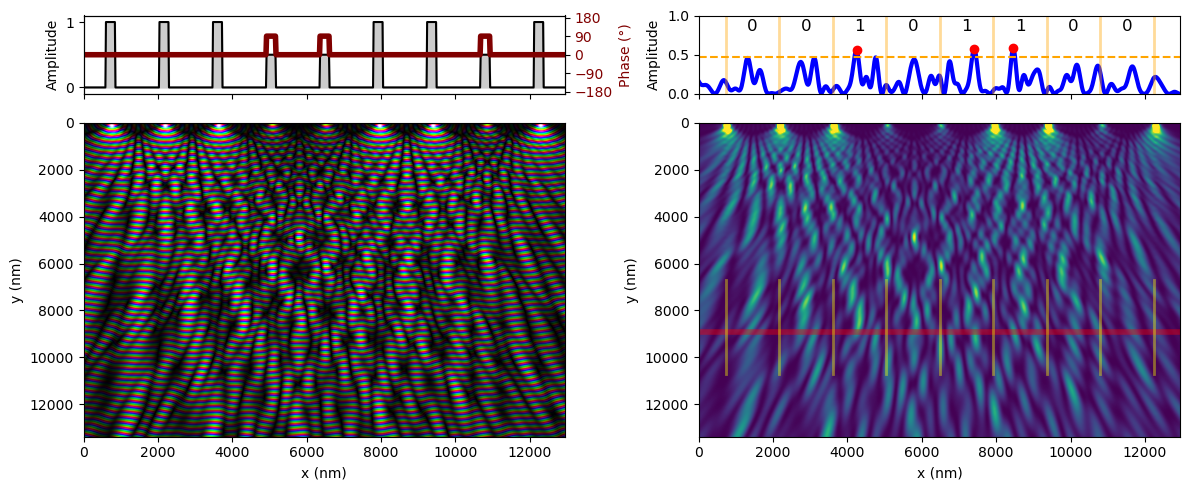

In [45]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs=[4,5,8],
        active_input_phase_shift=np.pi/2,
        active_input_amplitude=0.5,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=0,  # nm
        w_axhl = 60, # nm,
        plots=True,
        one_d_phase=False
    )

In [7]:
def generate_all_subsets(lst):
    # Collect all subsets (combinations) of all lengths from 1..len(lst)
    all_subsets = []
    for r in range(1, len(lst) + 1):
        for combo in combinations(lst, r):
            # Convert each combination to a list
            all_subsets.append(list(combo))
    return all_subsets

In [ ]:
input_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
result = generate_all_subsets(input_list)
for subset in result:
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs=[4,5,8],
        active_input_phase_shift=np.pi/2,
        active_input_amplitude=0.5,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=0,  # nm
        w_axhl = 60, # nm,
        plots=True,
        one_d_phase=False
    )
    print(subset, tt)

[1] [0. 0. 0. 1. 1. 0. 0. 0.]
[2] [0. 0. 0. 1. 1. 1. 0. 0.]
[3] [0. 0. 0. 1. 1. 1. 0. 0.]
[4] [0. 0. 0. 1. 1. 1. 0. 0.]
[5] [0. 0. 0. 1. 1. 1. 0. 0.]
[6] [0. 0. 1. 1. 1. 0. 0. 0.]
[7] [0. 0. 1. 1. 1. 0. 0. 0.]
[8] [0. 0. 1. 1. 1. 0. 0. 0.]
[9] [0. 0. 0. 1. 1. 0. 0. 0.]
[1, 2] [0. 0. 0. 1. 1. 1. 0. 0.]
[1, 3] [0. 0. 0. 1. 1. 1. 0. 0.]
[1, 4] [0. 0. 0. 1. 1. 1. 0. 0.]
[1, 5] [0. 0. 0. 1. 1. 0. 0. 0.]
[1, 6] [0. 0. 0. 1. 1. 0. 0. 0.]
[1, 7] [0. 0. 0. 1. 1. 0. 0. 0.]
[1, 8] [0. 0. 0. 1. 1. 0. 0. 0.]
[1, 9] [0. 0. 0. 1. 1. 0. 0. 0.]
[2, 3] [0. 0. 0. 1. 1. 1. 1. 0.]
[2, 4] [0. 0. 0. 1. 1. 1. 0. 0.]
[2, 5] [0. 0. 0. 1. 1. 1. 0. 0.]
[2, 6] [0. 0. 0. 1. 1. 1. 0. 0.]
[2, 7] [0. 0. 0. 1. 1. 1. 0. 0.]
[2, 8] [0. 0. 1. 1. 1. 1. 0. 0.]
[2, 9] [0. 0. 0. 1. 1. 1. 0. 0.]
[3, 4] [0. 0. 0. 1. 1. 1. 1. 0.]
[3, 5] [0. 0. 0. 1. 1. 1. 0. 0.]
[3, 6] [0. 0. 0. 1. 1. 1. 0. 0.]
[3, 7] [0. 0. 0. 1. 1. 1. 0. 0.]
[3, 8] [0. 0. 1. 1. 1. 0. 0. 0.]
[3, 9] [0. 0. 0. 1. 1. 0. 0. 0.]
[4, 5] [0. 0. 0. 1. 1. 1. 0. 0.]
[4, 